# Notebook Overview U-Net
This notebook focuses on U-Net tracking:
* Fully tracking with U-Net
* Using U-Net as fallback to lucas-Kanade

The code:
1) Take all csv fails, inpaints them, and normalises them
2) Pre-processes them the same way for u-net model
3) Apply u-net for each frame and store results as an mp4 video


In [2]:
#All imports:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog
import cv2
from skimage import exposure
from skimage.restoration import inpaint, inpaint_biharmonic
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split


In [3]:
print(np.__version__)


1.26.4


# Data Pre-processing

In [4]:
def inpaint_biharmonic_csv(csv_img):
  data = pd.read_csv(csv_img, header=None)
  thermal_image = data.to_numpy()
  #load raw csv temp. file
  lower_threshold = 24
  upper_threshold = 28

  #Creating mask of fence: where the temperature is within the threshold will be white
  fence_mask = (thermal_image >= lower_threshold) & (thermal_image <= upper_threshold)

  #Dilating that fence-mask + Normalise:
  fence_mask = fence_mask.astype(np.uint8) * 255
  kernel = np.ones((3, 3))
  dilated_mask_temp = cv2.dilate(fence_mask, kernel, iterations=3)
  #inpainting using biharmonic
  inpainted_image_temp = inpaint.inpaint_biharmonic(thermal_image, dilated_mask_temp )
  inpainted_scaled = cv2.normalize(inpainted_image_temp, None, 0, 255, cv2.NORM_MINMAX)
  inpainted_scaled = inpainted_scaled.astype(np.uint8)

  return inpainted_scaled

In [5]:
#Transforms required for U-net/ Pre-processing the same for U-net
def base_transform(image):
    transform = transforms.Compose([
        transforms.Resize((256, 320)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    return transform(image)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [7]:
#Loading the same model setup: U-net with ResNet18 encoder
model = smp.Unet(
    encoder_name="resnet18", 
    encoder_weights="imagenet", #pre-trained
    in_channels=3, #copying 3 grayscale images  
    classes=1,  #Binary segmentation: nose or not 
    activation=None )  #Output doesn't require sigmoid since cross-binary Entropy loss function uses sigmoid already
model.to(device)
summary(model, input_size=(1, 3, 256, 320)) 

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 1, 256, 320]          --
├─ResNetEncoder: 1-1                          [1, 3, 256, 320]          --
│    └─Conv2d: 2-1                            [1, 64, 128, 160]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 160]         128
│    └─ReLU: 2-3                              [1, 64, 128, 160]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 80]           --
│    └─Sequential: 2-5                        [1, 64, 64, 80]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 80]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 80]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 40]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 40]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 40]          295,42

In [8]:
#Load model weights
model.load_state_dict(torch.load("Model_best.pth", map_location=device))

#Using CPU
model.to(device)

summary(model, input_size=(1, 3, 256, 256))


Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 1, 256, 256]          --
├─ResNetEncoder: 1-1                          [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]          295,42

In [9]:
#Function to get middle point of nose mask (for tracking)
def calculate_centroid(binary_image):
    #Find all white pixel coordinates (where value is 255)
    white_pixels = np.column_stack(np.where(binary_image == 255))
    
    if white_pixels.shape[0] == 0:
        white_pixels = None
    
    #Compute centroid
    y_cen, x_cen = np.mean(white_pixels, axis=0)
    return (round(y_cen), round(x_cen)) 

# Running U-Net

In [10]:
#Folder with new (never seen before) csv frame sequence
csv_folder_path = "test_sequence_for_tracking"
csv_files = sorted(glob.glob(os.path.join(csv_folder_path, '*.csv')))

#Check for CSV path doesn't exist
if len(csv_files) == 0:
    raise Exception("No CSV files found in the specified folder.")

#Output path
output_video_path = os.path.join(os.path.expanduser("~"), "Desktop", "Only u-net.mp4") 

#First frame
first_frame_inpaint = inpaint_biharmonic_csv(csv_files[0])
frame_height, frame_width = first_frame_inpaint.shape[:2]
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_idx = 0

for frame in csv_files:
    #each frame including the first one, it will find the nose
    #Inpaint and normalise frame
    inpainted_frame = inpaint_biharmonic_csv(frame)
    pil_frame = Image.fromarray(inpainted_frame)

    #Pre-process frame is uniform way for u-net
    test_img_transformed = base_transform(pil_frame).unsqueeze(0).to(device)

    #Get preidction from u-net for that frame
    model.eval()
    with torch.no_grad():
        raw_output = model(test_img_transformed)
        output = torch.sigmoid(raw_output).squeeze(0).cpu().numpy()
        output = (output > 0.5).astype(np.uint8) * 255
        output = output.squeeze(0)

    #If a prediction is made draw the circle
    frame_bgr = cv2.cvtColor(inpainted_frame, cv2.COLOR_GRAY2BGR)
    try:
        centroid = calculate_centroid(output)
        y, x = centroid
        cv2.circle(frame_bgr, (int(x), int(y)), 10, (0, 255, 0), 2)
    except ValueError:
        #incas no prediction is made
        print(f"Tracking lost at frame {frame_idx}")

    #Write the frame index
    cv2.putText(frame_bgr, f"Frame: {frame_idx}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    out.write(frame_bgr)
    frame_idx += 1

out.release()
print("Video was saved at :", output_video_path)


Tracking lost at frame 13
Tracking lost at frame 20
Tracking lost at frame 109
Video was saved at : /Users/iadician/Desktop/Only u-net.mp4


# Combined Approach
Below we have combined all possible approaches. 
1) Starts with lucas tracking with is efficient and works well. If tracking error is too large (above 5)
2) Will get U-net predictions (which tend to generalise better than lucas-kanade but more computationally expensive) and check model's confidence score
3) If model is making the correct estimation (high), then we can use it's predictions. If not, then we will re-vert to manual detection
4) Manual detection in worst case.

This system works well because the user can adjust how much to trust the machine predictions.

Currently the way U-net predictions are trusted is if both conditions hold:
* At least one nose pixel with more than 0.99 accuracy from sigmoid predictions (What the model thinks is 0.99 accuracy)
* 270 or more total pixel for the nose area (avoids noisy or really small prediction masks).

In [11]:
#Function that allows manual re-detection
#get user's clicks from screen

def get_clicked_coordinates(image):
    #Check to make image into Numpy array 
    if isinstance(image, np.ndarray):
        image = np.clip(image, 0, 255).astype(np.uint8)  
        image = Image.fromarray(image)

    #To store coordinates
    selected_coordinates = {"x": None, "y": None}

    #Create Tkinter Object
    window = tk.Tk()
    window.title("Click Once to Select a Point & Close Window")

    frame = tk.Frame(window)
    frame.pack(fill=tk.BOTH, expand=tk.YES)

    canvas = tk.Canvas(frame, width=image.width, height=image.height)
    canvas.pack(fill=tk.BOTH, expand=tk.YES)

    tk_image = ImageTk.PhotoImage(image)
    canvas.create_image(0, 0, anchor=tk.NW, image=tk_image)

    def get_coordinates(event):
        #Only stores first coordinates
        if selected_coordinates["x"] is None and selected_coordinates["y"] is None: 
            selected_coordinates["x"] = event.x
            selected_coordinates["y"] = event.y

            #Shows coordinates selected
            canvas.create_line(event.x - 10, event.y, event.x + 10, event.y, fill="red", width=2)  #Horizontal line
            canvas.create_line(event.x, event.y - 10, event.x, event.y + 10, fill="red", width=2)  #Vertical line
            
            print(f"Selected Coordinates: ({event.x}, {event.y})")

    #When click anywhere on canvas, it will trigger the get_coordinate function to store the coordinates
    canvas.bind("<Button-1>", get_coordinates)

    #User has to closer the window (had issue if done automatic)
    window.mainloop()

    if selected_coordinates["x"] is not None and selected_coordinates["y"] is not None:
        return (selected_coordinates["x"], selected_coordinates["y"])
    else:
        print("No point selected.")
        return None


In [12]:
#New unseen csv frame sequence
#Using the same difficult test sequence
csv_folder_path = "test_sequence_for_tracking"
csv_files = sorted(glob.glob(os.path.join(csv_folder_path, '*.csv')))
if len(csv_files) == 0:
    raise Exception("No CSV files found in the specified folder.")

#where the video will be outputted
output_video_path = os.path.join(os.path.expanduser("~"), "Desktop", "Combined_working.mp4") 

#Process first frame to get dimensions
first_csv = csv_files[0]
first_frame_inpaint = inpaint_biharmonic_csv(first_csv)
frame_height, frame_width = first_frame_inpaint.shape[:2]

#Setup VideoWriter (30 FPS, MP4 format)
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

#Get initial tracking point manually
image = Image.fromarray(first_frame_inpaint)
x, y = get_clicked_coordinates(image)
initial_point = np.array([[x, y]], dtype=np.float32)
p0 = initial_point.reshape(-1, 1, 2)
prev_gray = first_frame_inpaint.copy()

#Annotate the first frame with the initial tracking point (draw green circle)
first_frame_bgr = cv2.cvtColor(first_frame_inpaint, cv2.COLOR_GRAY2BGR)
cv2.circle(first_frame_bgr, (int(initial_point[0, 0]), int(initial_point[0, 1])), 10, (0, 255, 0), 1)
out.write(first_frame_bgr)

#Lucas–Kanade Optical Flow Parameters
lk_params = dict(
    winSize  = (15, 15),
    maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

error_threshold = 5  
frame_idx = 0
tracked_coordinates = [(int(initial_point[0, 0]), int(initial_point[0, 1]))]
pixel_values = [first_frame_inpaint[int(initial_point[0, 1]), int(initial_point[0, 0])]]

#Process each frame after the first one (first one done manually)
for csv_file in csv_files[1:]:
    #Inpaint with biharmonic
    inpainted_frame = inpaint_biharmonic_csv(csv_file)
    frame_gray = inpainted_frame.copy()
    
    #Compute optical flow (Lucas–Kanade)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, p0, None, **lk_params)
    
    new_point = None
    use_unet = False  #Flag to indicate whether U-Net prediction was used
    
    #If LK fails or error is too high, try U-Net detection
    if p1 is None or st[0][0] == 0 or (err is not None and err[0][0] > error_threshold):
        print(f"Frame {frame_idx}: LK tracking lost or error ({err[0][0] if err is not None else 'N/A'}) exceeds threshold.")
        print("Attempting U-Net detection...")
        pil_frame = Image.fromarray(frame_gray)
        input_tensor = base_transform(pil_frame).unsqueeze(0).to(device)

    
        with torch.no_grad():
            unet_output = model(input_tensor)
            unet_output = torch.sigmoid(unet_output)
            unet_output = unet_output.squeeze(0).cpu().numpy()
            if unet_output.ndim == 3:
                unet_output = unet_output[0]

        #From output see if U-Net predicition is likely to be correct
        max_conf = unet_output.max() #highest pixel acucracy 
        num_pixels = np.sum(unet_output > 0.5) #number of pixels of nose
        print(f"Frame {frame_idx}: U-Net max confidence = {max_conf:.2f}, num_pixels = {num_pixels}")
        if max_conf > 0.99 and num_pixels > 270:
            #Use U-Net prediction:
            binary_mask = (unet_output > 0.5).astype(np.uint8) * 255
            centroid = calculate_centroid(binary_mask)
            new_point = np.array([[[centroid[1], centroid[0]]]], dtype=np.float32)
            use_unet = True
        else:
            #U-Net not confident enough, fallback to manual detection
            print(f"Frame {frame_idx}: U-Net confidence too low. Requesting manual detection.")
            new_coords = get_clicked_coordinates(Image.fromarray(frame_gray))  # returns (x, y)
            new_point = np.array([[[new_coords[0], new_coords[1]]]], dtype=np.float32)
    else:
        #If Lucas-kanade doesn't fail
        new_point = p1.copy()
    
    #Store point if want to plot temperature curves
    pt = new_point[0][0]
    tracked_coordinates.append((int(pt[0]), int(pt[1])))
    pixel_val = frame_gray[int(pt[1]), int(pt[0])]
    pixel_values.append(pixel_val)
    
   
    frame_bgr = cv2.cvtColor(inpainted_frame, cv2.COLOR_GRAY2BGR)
    # Draw tracking point:
    # If U-Net was used as fallback, draw a blue circle; otherwise, draw a green circle (explains earlier need for flag)
    if use_unet:
        cv2.circle(frame_bgr, (int(pt[0]), int(pt[1])), 10, (255, 0, 0), 2)
    else:
        cv2.circle(frame_bgr, (int(pt[0]), int(pt[1])), 10, (0, 255, 0), 2)
    
    #Overlay frame number (in red) in bottom-right corner
    text = f"Frame: {frame_idx}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)
    cv2.putText(frame_bgr, text, (10, 30), font, font_scale, (0, 0, 255), thickness)
    
    out.write(frame_bgr)
    
    #Update for next frame
    prev_gray = frame_gray.copy()
    p0 = new_point.copy()
    frame_idx += 1

out.release()
print("Tracking complete. Output video saved at:", output_video_path)


Selected Coordinates: (270, 144)
Frame 5: LK tracking lost or error (8.125139236450195) exceeds threshold.
Attempting U-Net detection...
Frame 5: U-Net max confidence = 1.00, num_pixels = 383
Frame 6: LK tracking lost or error (7.396805763244629) exceeds threshold.
Attempting U-Net detection...
Frame 6: U-Net max confidence = 1.00, num_pixels = 324
Frame 18: LK tracking lost or error (6.078610897064209) exceeds threshold.
Attempting U-Net detection...
Frame 18: U-Net max confidence = 1.00, num_pixels = 262
Frame 18: U-Net confidence too low. Requesting manual detection.
Selected Coordinates: (292, 154)
Frame 21: LK tracking lost or error (10.867361068725586) exceeds threshold.
Attempting U-Net detection...
Frame 21: U-Net max confidence = 1.00, num_pixels = 323
Frame 22: LK tracking lost or error (5.554722309112549) exceeds threshold.
Attempting U-Net detection...
Frame 22: U-Net max confidence = 1.00, num_pixels = 441
Frame 28: LK tracking lost or error (8.047361373901367) exceeds thr

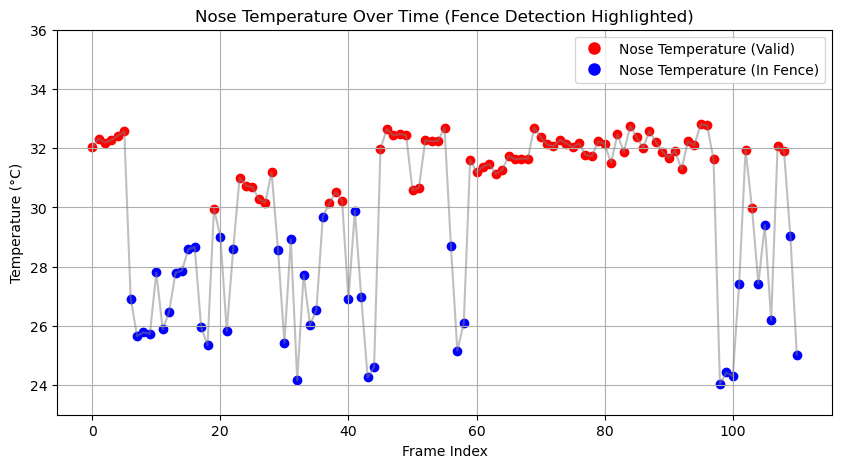

In [13]:
#Plotting just temperature curve
upper_threshold = 29.9

real_temperatures = []
colors = [] 
for i, csv_file in enumerate(csv_files[:len(tracked_coordinates)]):
    thermal_frame = np.loadtxt(csv_file, delimiter=",") 
    #Get tracked coordinates
    x, y = tracked_coordinates[i]
    #Extract temperature  
    temp_value = thermal_frame[y, x]  
    real_temperatures.append(temp_value)

    #Assign color: blue if in fence range, red otherwise
    if temp_value <= upper_threshold:
        colors.append('b') 
    else:
        colors.append('r')  


plt.figure(figsize=(10, 5))
for i in range(len(real_temperatures)):
    plt.scatter(i, real_temperatures[i], color=colors[i])

plt.plot(range(len(real_temperatures)), real_temperatures, linestyle='-', color='gray', alpha=0.5)

red_marker = mlines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=8, label="Nose Temperature (Valid)")
blue_marker = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=8, label="Nose Temperature (In Fence)")

plt.ylim(23, 36)
plt.xlabel("Frame Index")
plt.ylabel("Temperature (°C)")
plt.title("Nose Temperature Over Time (Fence Detection Highlighted)")
plt.legend(handles=[red_marker, blue_marker])  # Add custom legend
plt.grid()
plt.savefig("nose_temperature_plot.png", dpi=600, bbox_inches='tight')
plt.show()


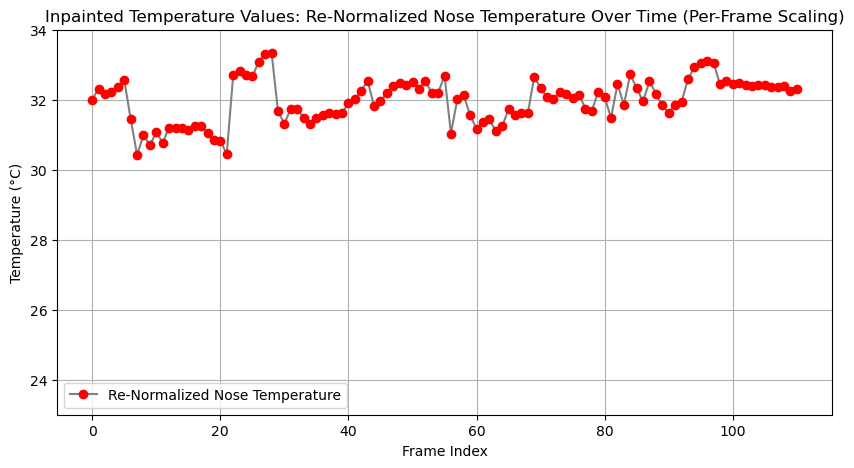

In [14]:
#Test: number of pixel values = the number of frames
if len(pixel_values) != len(csv_files):
    raise Exception(f"Mismatch: {len(pixel_values)} pixel values vs {len(csv_files)} frames.")

#List to store re-normalized temperature values
inpainted_Temps = []

for i, csv_file in enumerate(csv_files):
    #For each frame in csv file
    thermal_frame = np.loadtxt(csv_file, delimiter=",")
    #Get it original temperature min and max
    temp_min = np.min(thermal_frame)
    temp_max = np.max(thermal_frame)

    #Get the nose inpainted value
    grayscale_pixel = pixel_values[i]

    #Reverse normalization: Convert grayscale (0-255) back to temperature for that nose inpainted value
    temperatu_value = ((grayscale_pixel / 255) * (temp_max - temp_min)) + temp_min

    #Store the re-normalized temperature value
    inpainted_Temps.append(temperatu_value)


plt.figure(figsize=(10, 5))
plt.plot(range(len(inpainted_Temps)), inpainted_Temps, marker='o', linestyle='-', color='gray', markeredgecolor='red', markerfacecolor ="red" ,label="Re-Normalized Nose Temperature")

plt.ylim(23, 34) 
plt.xlabel("Frame Index")
plt.ylabel("Temperature (°C)")
plt.title("Inpainted Temperature Values: Re-Normalized Nose Temperature Over Time (Per-Frame Scaling)")
plt.legend()
plt.grid()
plt.savefig("Inpainted_values_plot.png", dpi=600, bbox_inches='tight')
plt.show()

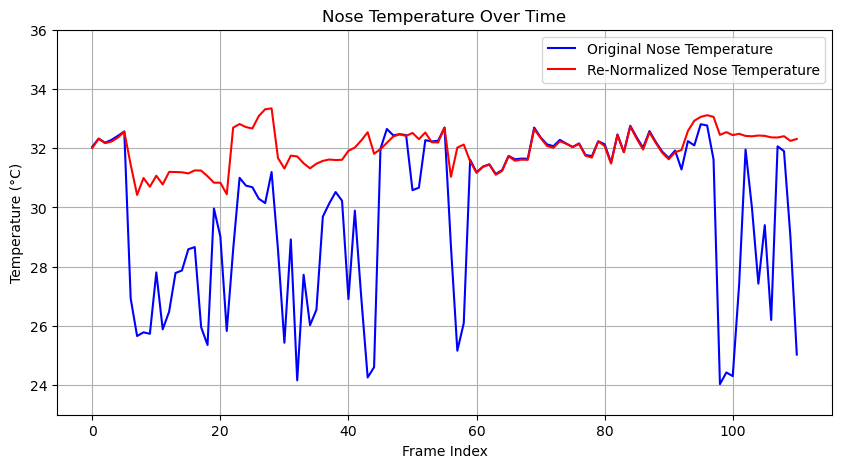

In [15]:
#Plotting both curves one on top of the other
inpainted_Temps = []
real_temperatures = []

for i, csv_file in enumerate(csv_files[:len(tracked_coordinates)]):
    #for each frame

    #get real nose value
    thermal_frame = np.loadtxt(csv_file, delimiter=",") 
    x, y = tracked_coordinates[i] 
    temp_value = thermal_frame[y, x] 
    real_temperatures.append(temp_value)

    #Re-normalise inpainted value
    temp_min = np.min(thermal_frame)
    temp_max = np.max(thermal_frame)
    grayscale_pixel = pixel_values[i]
    temperature_value = ((grayscale_pixel / 255) * (temp_max - temp_min)) + temp_min
    inpainted_Temps.append(temperature_value)

#Plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(real_temperatures)), real_temperatures, linestyle='-', color='blue', label='Original Nose Temperature')
plt.plot(range(len(inpainted_Temps)), inpainted_Temps, linestyle='-', color='red', label='Re-Normalized Nose Temperature')

plt.ylim(23, 36)
plt.xlabel("Frame Index")
plt.ylabel("Temperature (°C)")
plt.title("Nose Temperature Over Time")
plt.legend()
plt.grid()
plt.savefig("Super-imposed-plot.png", dpi=600, bbox_inches='tight')
plt.show()
